## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load dataset

In [2]:
df = pd.read_csv("german_credit_data_processed.csv")
df.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## Handle missing values

In [3]:
# "most_frequent" imputation
imputer = SimpleImputer(strategy='most_frequent')
df[['saving_accounts', 'checking_account']] = imputer.fit_transform(df[['saving_accounts', 'checking_account']])

# Check again to confirm
print("Missing values after imputation:\n", df.isnull().sum())

Missing values after imputation:
 age                 0
sex                 0
job                 0
housing             0
saving_accounts     0
checking_account    0
credit_amount       0
duration            0
purpose             0
risk                0
dtype: int64


## Feature Engineering

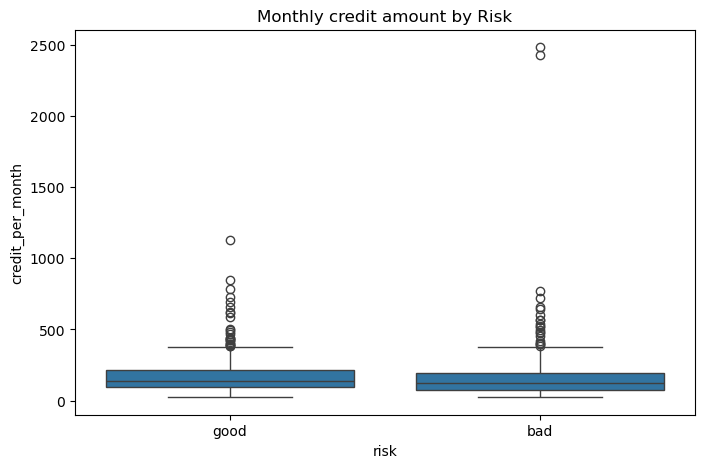

In [4]:
# Create a new feature: average monthly credit
df['credit_per_month'] = df['credit_amount'] / df['duration']


# Visualize distribution by risk
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x='risk', y='credit_per_month', data=df, ax=ax)
ax.set_title("Monthly credit amount by Risk")
plt.show()

## Binning Continuous Variables

In [5]:
# Age, duration, credit bins as integers
df['age_bin'] = pd.cut(df['age'], bins=[18, 30, 40, 50, 60, 70, 80], labels=[1,2,3,4,5,6]).astype(int)
df['duration_bin'] = pd.cut(df['duration'], bins=[1, 12, 24, 36, 48, 60, 72], labels=[1,2,3,4,5,6]).astype(int)

credit_bins = list(range(1, 20001, 1000))
credit_labels = list(range(1, len(credit_bins)))
df['credit_amount_bin'] = pd.cut(df['credit_amount'], bins=credit_bins, labels=credit_labels).astype(int)

# Drop original continuous columns
df.drop(['age', 'duration', 'credit_amount'], axis=1, inplace=True)

print("Shape after numeric binning:", df.shape)
print(df[['age_bin','duration_bin','credit_amount_bin']].head())

Shape after numeric binning: (1000, 11)
   age_bin  duration_bin  credit_amount_bin
0        5             1                  2
1        1             4                  6
2        3             1                  3
3        3             4                  8
4        4             2                  5


## Encode Categorical Variables

In [6]:
# Ordinal encoding for features with natural order
ordinal_features = ['saving_accounts', 'checking_account']
ordinal_encoder = OrdinalEncoder(
categories=[['little', 'moderate', 'quite rich', 'rich'],
['little', 'moderate', 'rich']]
)
df[ordinal_features] = ordinal_encoder.fit_transform(df[ordinal_features])

# One-hot encoding for nominal categorical features
df = pd.get_dummies(df, columns=['risk','sex','housing','purpose'], drop_first=True)
df.head()

,job,saving_accounts,checking_account,credit_per_month,age_bin,duration_bin,credit_amount_bin,risk_good,sex_male,housing_own,housing_rent,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,2,0.0,0.0,194.833333,5,1,2,True,True,True,False,False,False,False,False,True,False,False
1,2,0.0,1.0,123.979167,1,4,6,False,False,True,False,False,False,False,False,True,False,False
2,1,0.0,0.0,174.666667,3,1,3,True,True,True,False,False,False,True,False,False,False,False
3,2,0.0,0.0,187.666667,3,4,8,True,True,False,False,False,False,False,True,False,False,False
4,2,0.0,0.0,202.916667,4,2,5,False,True,False,False,True,False,False,False,False,False,False


## Split Features and Target

In [7]:
X = df.drop('risk_good', axis=1)
y = df['risk_good']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=123, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Train shape: (700, 17)  Test shape: (300, 17)


## Balance Classes with SMOTE

Class distribution before SMOTE:
 risk_good
True     0.7
False    0.3
Name: proportion, dtype: float64
Class distribution after SMOTE:
 risk_good
True     0.5
False    0.5
Name: proportion, dtype: float64


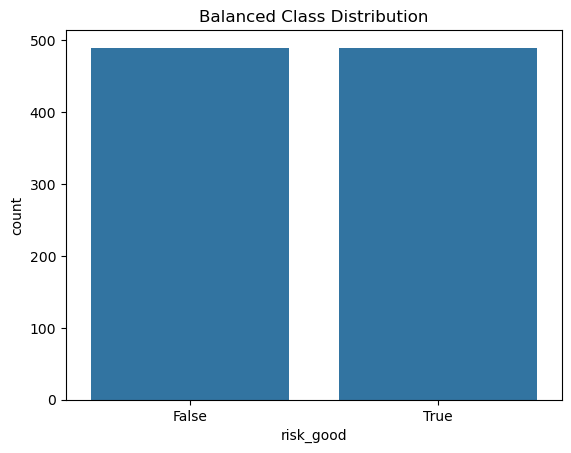

In [8]:
# Check class distribution before SMOTE
print("Class distribution before SMOTE:\n", y_train.value_counts(normalize=True))

# Apply SMOTE
smote = SMOTE(random_state=123)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:\n", y_train_res.value_counts(normalize=True))

# Plot balanced classes
sns.countplot(x=y_train_res)
plt.title("Balanced Class Distribution")
plt.show()

## Feature Scaling

In [9]:
# Standardize continuous variables
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

## Save the datasets for modeling

In [10]:
np.save("X_train_res_scaled.npy", X_train_res_scaled)
np.save("X_test_scaled.npy", X_test_scaled)
np.save("y_train_res.npy", y_train_res)
np.save("y_test.npy", y_test)